<a href="https://colab.research.google.com/github/ryegunde/Kaggle-Titanic-Ken-Jee-Submission/blob/main/Titanic_Ken_Jee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is another attempt at the Titanic Kaggle Competation, this time I will be going through and explaining a notebook that placed in the top 12% of all notebooks. This notebook is based off of Ken Jee's submission

#Overview
1) Understand the shape of the data (Histograms, box plots, etc.)

2) Data Cleaning

3) Data Exploration

4) Feature Engineering

5) Data Preprocessing for Model

6) Basic Model Building

7) Model Tuning

8) Ensemble Modle Building

9) Results

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
import matplotlib.pyplot as plt

Here import the packages we wil be using. For this analysis, we will be exclusively working with the Training set. We will be validating based on data from the training set as well. For our final submissions, we will make predictions based on the test set. This allows us to estimate our generalization error before we even make a submission. This means we can test many models and many hyperparameters in order to find the optimal model.


In [3]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1                      #Adds another column and assigns each record to 1
test['train_test'] = 0                          #Adds another column and assigns each record to 0
test['Survived'] = np.NaN                       #Adds the Survived column to test and sets each record to NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

We want our training set and our test set to have the same shape so here we will make sure that each has the same columns

#Project Planning

When starting any project, I like to outline the steps that I plan to take. Below is the rough outline that I created for this project.


*   Understand nature of the data .info() .describe()
*   Histograms and boxplots 
*   Value counts (Barcharts for categorical data)
*   Missing data (Remove or impute(assign a value))
*   Correlation between the features (extremely useful in regression problems
*   Explore interesting themes
  *   Wealthy survive? 
  *   By location
  *   Age scatterplot with ticket price
  *   Young and wealthy Variable? 
  *   Total spent? 
*   Feature engineering (focus on improving data)
*   preprocess data together or use a transformer? 
  *   use label for train and test
*   Scaling?

*   Model Baseline
*   Model comparison with CV

#Light Data Exploration

##1) For numeric data
* Made histograms to understand distributions
* Corrplot
* Pivot table comparing survival rate across numeric variables

#2) For Categorical Data
* Made bar charts to understand balance of classes
* Made pivot tables to understand relationship with survival

In [4]:
#quick look at our data types & null counts 
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


As we can see the Age and Cabin features vectors have quite a bit of null values, so we need to start thinking of how we are going to handle these values.

We also get to see each feature's object type

In [5]:
# to better understand the numeric data, we want to use the .describe() method. 
# This gives us an understanding of the central tendencies of the data 
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [6]:
survivors = training[training.Survived == 1]
survivors.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,342.000000,342.0,342.000000,290.000000,342.000000,342.000000,342.000000,342.0
mean,444.368421,1.0,1.950292,28.343690,0.473684,0.464912,48.395408,1.0
std,252.358840,0.0,0.863321,14.950952,0.708688,0.771712,66.596998,0.0
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,250.750000,1.0,1.000000,19.000000,0.000000,0.000000,12.475000,1.0
50%,439.500000,1.0,2.000000,28.000000,0.000000,0.000000,26.000000,1.0
75%,651.500000,1.0,3.000000,36.000000,1.000000,1.000000,57.000000,1.0
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200,1.0


In [7]:
#quick way to separate numeric columns
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [8]:
# look at numeric and categorical values separately 
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


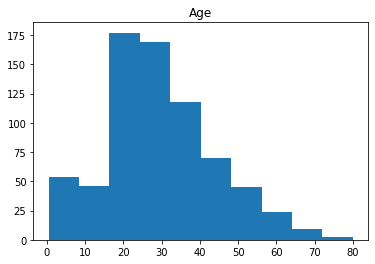

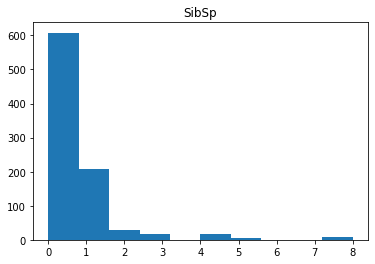

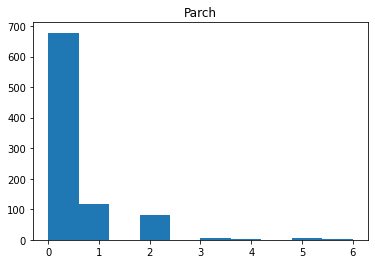

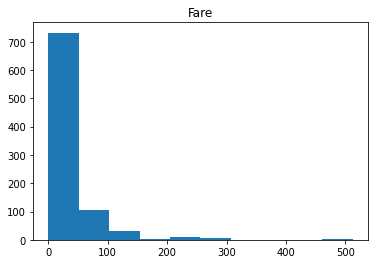

In [9]:
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

* Age seems to roughly follow a normal distribution
* We may actually want to normalize the fair feature because there is a huge spike at a very low price
* Parch and SibSp have so few categories that we can just leave them how they are

### Lets try to find some correlations between our features

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


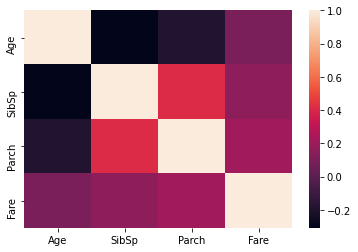

In [10]:
print(df_num.corr())
sns.heatmap(df_num.corr())

If we are using a regression model we want to avoid multicollinearity which is when two or more of our features (variables) are highly linearily related because this can have a huge impact on our model

In [11]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


### Now lets make bar graphs for our categorical data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


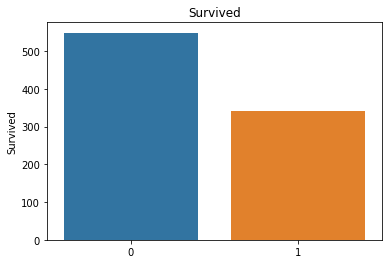

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


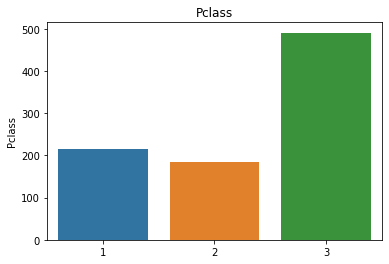

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


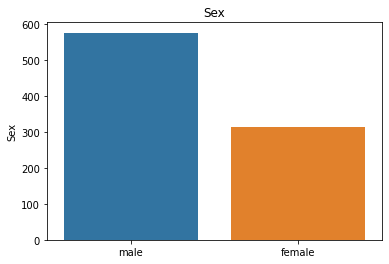

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


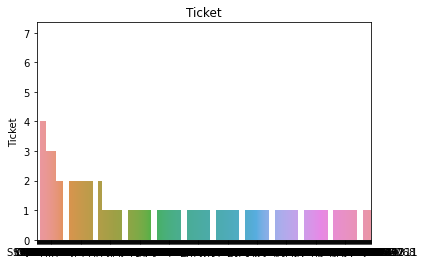

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


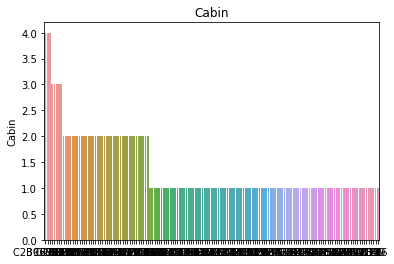

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


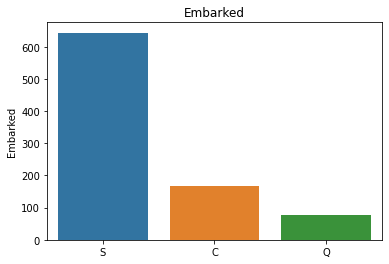

In [12]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()\

Cabin and ticket graphs are very messy. This is an area where we may want to do some feature engineering!

In [13]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


From this it looks like those in 1st class had a much higher survival rate.

Women also had a much higher survival rate.

Possibly those who embared from C had a higher survival rate

## Feature Engineering
1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)

2) Tickets - Do different ticket types impact survival rates?

3) Does a person's title relate to survival rates?

### First we will do the Cabin feature

In [14]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
training['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [15]:
pd.pivot_table(training, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [16]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

In [17]:
#comparing surivial rate by cabin
print(training.cabin_adv.value_counts())
pd.pivot_table(training,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Note: n is the number of null values associated with the cabin feature in the data set

Instead of just dropping these null values, lets give them their own category. From the table above it seems like the nan value people have a low chance of survival which may be insightful to our model.

###Okay now lets try to feature engineer for our tickets variable

In [18]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [19]:
training['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

In [20]:
#lets us view all rows in dataframe through scrolling. This is for convenience 
pd.set_option("max_rows", None)
training['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
fcc            5
c              5
pp             3
sopp           3
wep            3
swpp           2
sotono2        2
ppp            2
scah           2
scahbasle      1
fa             1
as             1
sca4           1
sp             1
fc             1
sc             1
casoton        1
sop            1
scow           1
Name: ticket_letters, dtype: int64

Doesn't look very insightful, too many small categories

In [21]:
#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(training,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [22]:
#survival rate across different tyicket types 
pd.pivot_table(training,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,pc,pp,ppp,sc,sca4,scah,scahbasle,scow,scparis,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,6.0,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,39.0,2.0,1.0,1.0,NaN,1.0,1.0,NaN,5.0,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


### Feature vector engineering for a person's title

In [23]:
#feature engineering on person's title 
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

In [24]:
training['name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Lady              1
Jonkheer          1
Sir               1
Capt              1
Ms                1
Mme               1
Don               1
the Countess      1
Name: name_title, dtype: int64

# Data Preprocessing for Model

**1)** Drop null values from Embarked (only 2)

**2)** Include only relevant variables (Since we have limited data, I wanted to exclude things like name and passanger ID so that we could have a reasonable number of features for our models to deal with)
Variables: 'Pclass', 'Sex','Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'


**3)** Do categorical transforms on all data. Usually we would use a transformer, but with this approach we can ensure that our traning and test data have the same colums. We also may be able to infer something about the shape of the test data through this method. I will stress, this is generally not recommend outside of a competition (use onehot encoder).

**4)** Impute data with mean for fare and age (Should also experiment with median)

**5)** Normalized fare using logarithm to give more semblance of a normal distribution

**6)** Scaled data 0-1 with standard scaler

(889,)

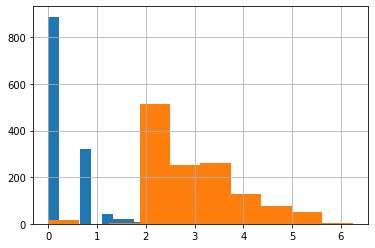

In [25]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

#impute nulls for continuous data 
#all_data.Age = all_data.Age.fillna(training.Age.mean())
all_data.Age = all_data.Age.fillna(training.Age.median())
#all_data.Fare = all_data.Fare.fillna(training.Fare.mean())
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [26]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

# Model Building (Baseline Validation Performance)

Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set basline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set.

* Naive Bayes (72.6%)
* Logistic Regression (82.1%)
* Decision Tree (77.6%)
* K Nearest Neighbor (80.5%)
* Random Forest (80.6%)
* Support Vector Classifier (83.2%)
* Xtreme Gradient Boosting (81.8%)
* Soft Voting Classifier - All Models (82.8%)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [29]:
#Can usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)         #Takes in our model, training data and labels, and runs 5 times using different testing set each time
print(cv)
print(cv.mean())                        #avg generalization score of the 5 runs

[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362


In [33]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train_scaled, y_train, cv = 5)
print(cv)
print(cv.mean())

[0.8258427  0.80898876 0.80337079 0.82022472 0.85310734]
0.8223068621849807


In [31]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75842697 0.74719101 0.8258427  0.74719101 0.8079096 ]
0.7773122579826065


In [32]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76966292 0.79775281 0.80898876 0.82022472 0.85310734]
0.8099473116231829


In [34]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.79213483 0.84831461 0.73595506 0.82485876]
0.8020504030978227


In [35]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.85393258 0.82022472 0.8258427  0.80337079 0.86440678]
0.8335555132355742


In [38]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.80898876 0.83707865 0.79213483 0.87570621]
0.8268266361962802


In [42]:
# Voting classifier takes all of the inputs and averages the results. 
# For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. 
# For this, you generally want odd numbers
# A "soft" classifier averages the confidence of each of the models. 
# If a the average confidence is > 50% that it is a 1 it will be counted as such
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82022472 0.80898876 0.83707865 0.79775281 0.85875706]
0.8245604011934236


# Model Tuned Performance

After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and XG boosted model to simplify testing time.

                          ModelBaseline |	Tuned Performance
    Naive Bayes	              72.6%	     NA
    Logistic Regression	      82.1%	     82.6%
    Decision Tree	            77.6%	     NA
    K Nearest Neighbor	       80.5%         83.0%
    Random Forest	            80.6%	     83.6
    Support Vector Classifier	83.2%	     83.2%
    Xtreme Gradient Boosting	 81.8%	     85.3%

In [43]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [44]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [47]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),    #Creates a list of 20 values
              'solver' : ['liblinear']}

#Will perform 5-fold cross validation for each parameter in the list of 40 parameters given by param_grid
# Note: We get 40 possible parameter cominations as we have 20 values for 'C' and 2 values for 'penalty' so 20 * 2 = 40
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)     #Creates a grid that is ready to do logistic regression on a 5-folds
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)                                        #Will return the best score
clf_performance(best_clf_lr,'Logistic Regression')

# We can view the scores for each parameter by looking at the grid_scores_ attribute of clr_lr, outputs a tuple for each parameter value
# clf_lr.grid_scores_[0].parameters
# clf_lr.grid_scores_[0].cv_validation_scores
# clf_lr.grid_scores_[0].mean_validation_scores

#examine the best model
#clf_lr.best_score_
#clf_lr.best_params_
#clf_lf.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished


In [48]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

# Note: Here we are tuning multiple parameters in our grid search not just k-neighbors. We are also tuning whether or not to use
# uniform or distance 'weights' and one of the 3 algorithms, and p either 1 or 2. above. so 4 * 2 * 3 * 2 = 48 parameter combinations
# and we run these 48 parameter combinations through 5-folds each so there are a total of 240 fits

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KNN
Best Score: 0.8279375357074843
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.1s finished


In [49]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  6.5min finished


SVC
Best Score: 0.8335555132355742
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [50]:
#Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. I took the best model from this and did a more granular search 
"""
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')"""

rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 17.4min finished


Random Forest
Best Score: 0.8358027042468101
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


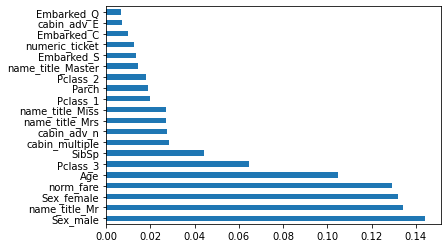

In [51]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [52]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1212 out of 1215 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:    6.4s finished


XGBoostError: ignored

In [ ]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)

# Model Additional Ensemble Approaches

1) Experimented with a hard voting classifier of three estimators (KNN, SVM, RF) (81.6%)

2) Experimented with a soft voting classifier of three estimators (KNN, SVM, RF) (82.3%) (Best Performance)

3) Experimented with soft voting on all estimators performing better than 80% except xgb (KNN, RF, LR, SVC) (82.9%)

4) Experimented with soft voting on all estimators including XGB (KNN, SVM, RF, LR, XGB) (83.5%)

In [ ]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('lr', best_lr)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=5))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=5).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=5).mean())

In [ ]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = 5, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train_scaled,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test_scaled)

In [ ]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train)
voting_clf_xgb.fit(X_train_scaled, y_train)

best_rf.fit(X_train_scaled, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_rf = best_rf.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test_scaled).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test_scaled).astype(int)

In [ ]:
#convert output to dataframe 
final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': test.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': test.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [ ]:
#track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

In [ ]:
comparison.difference_hard_all.value_counts()

In [ ]:
#prepare submission files 
submission.to_csv('submission_rf.csv', index =False)
submission_2.to_csv('submission_vc_hard.csv',index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_4.to_csv('submission_vc_all.csv', index=False)
submission_5.to_csv('submission_vc_xgb2.csv', index=False)